# Import Dependencies

In [1]:
import os
import vertexai

/Users/ashutosh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
!gcloud config set project bot-1-361805
!gcloud auth application-default login -q

Updated property [core/project].
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=vSSybslvOjeQUnbnULlWoJDk3Xd2MT&access_type=offline&code_challenge=jhrJeVXDAbgOocOMzCuxYATNrhjm6xcVlfN2gxitmX8&code_challenge_method=S256


Credentials saved to file: [/Users/ashutosh/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "bot-1-361805" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


# Prepare and Load Data

In [3]:
PROJECT_ID = os.environ.get('PROJECT_ID')
REGION = os.environ.get('REGION')
# VERTEX_API_KEY = os.environ.get('VERTEX_API_KEY')

In [4]:
vertexai.init(project=PROJECT_ID, location=REGION)

In [5]:
import logging
import zipfile
import requests

logging.basicConfig(level=logging.INFO)

data_url = 'https://storage.googleapis.com/benchmarks-artifacts/langchain-docs-benchmarking/cj.zip'
filename = 'cj.zip'
with open(filename, 'wb') as f:
    response = requests.get(data_url)
    f.write(response.content)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('./cj/cj.pdf')
docs = loader.load()
tables = []
texts = [d.page_content for d in docs]

In [7]:
texts[0]

'11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball\nhttps://cloudedjudgement.substack.com/p/clouded-judgement-111023 1/21Clouded Judgement 11.10.23 - OpenAI\nUpdates + Datadog Gives the All-Clear?\nJAMIN BALL\nNOV 10, 2023\n2 Share\nEvery week I’ll provide updates on the latest trends in cloud so\x00ware companies. Follow along to\nstay up to date!\nOpen AI U pdates\nOpenAI had their big developer day this week, and I wanted to call out two key announcements\n(and trends): increasing context windows and decreasing costs.\nWhen I think about the monetization of AI (and which “layers” monetize \x00rst) I’ve always\nthought it would follow the below order, with each layer lagging the one that comes before it.\n1. Raw silicon (chips like Nvidia bought in large quantities to build out infra to service\nupcoming demand).\n2. Model providers (OpenAI, Anthropic, etc as companies start building out AI).\n35\nType your email... Subscribe'

In [8]:
len(texts)

21

# Generate Text Summaries

In [9]:
from langchain_google_vertexai import VertexAI, ChatVertexAI, VertexAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda

In [10]:
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Generates text and table summaries for retrieval.
    Args:
        texts (list): List of text elements to be summarized.
        tables (list): List of table elements to be summarized.
        summarize_texts (bool, optional): Flag indicating whether to summarize texts. Defaults to False.
    Returns:
        tuple: A tuple containing the text summaries and table summaries.
    """

    
    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
        These summaries will be embedded and used to retrieve the raw text or table elements. \
        Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = PromptTemplate.from_template(prompt_text)
    empty_response = RunnableLambda(
        lambda x: AIMessage(content="Error processing Document.")
    )

    # Text summary chain
    model = VertexAI(
        temperature=0,
        model_name="gemini-pro",
        max_output_tokens = 1024
    ).with_fallbacks([empty_response])

    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries

In [11]:
# Get text and table summaries
text_summaries, table_summaries = generate_text_summaries(texts, tables, summarize_texts=True)
len(text_summaries)

I0000 00:00:1723109057.887949 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


21

In [12]:
text_summaries[0]

'## OpenAI Updates and Datadog\n\n**OpenAI Developer Day Announcements:**\n\n* **Increased context windows:** This allows models to process more information and generate more comprehensive responses.\n* **Decreased costs:** This makes OpenAI\'s models more accessible to a wider range of users.\n\n**Monetization of AI:**\n\n* The author believes that AI monetization will follow a specific order, with each layer lagging behind the one before it.\n* The order is as follows:\n    * Raw silicon (e.g., Nvidia chips)\n    * Model providers (e.g., OpenAI, Anthropic)\n    * Applications (e.g., Datadog)\n    * End users (e.g., businesses using AI-powered tools)\n\n**Datadog:**\n\n* Datadog is an application that uses AI to monitor and analyze cloud infrastructure.\n* The author notes that Datadog has given the "all-clear" for OpenAI\'s recent updates, suggesting that they are not a cause for concern. \n'

# Generate Image Summaries

In [13]:
import base64

from langchain_core.messages import HumanMessage

In [14]:
def encode_image(image_path):
    """
    Encodes the image located at the given image_path into a base64 encoded string.
    Parameters:
    image_path (str): The path to the image file.
    Returns:
    str: The base64 encoded string representation of the image.
    """
    
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string

In [15]:
def image_summarize(image_base64, prompt):
    """
    Summarizes an image using a pre-trained Gemini Pro Vision model.
    Args:
        image_base64 (str): The base64 encoded image.
        prompt (str): The prompt for generating the image summary.
    Returns:
        str: The generated image summary.
    """

    model = ChatVertexAI(model_name="gemini-pro-vision", max_output_tokens=1024)

    msg = model(
        [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}
                    },
                ]
            )
        ]
    )

    return msg.content

In [16]:
def generate_image_summaries(image_dir):
    """
    Generates image summaries for retrieval.
    Args:
        image_dir (str): The directory path where the images are stored.
    Returns:
        tuple: A tuple containing two lists. The first list contains the base64 encoded images, 
        and the second list contains the generated image summaries.
    """

    # Store base64 encoded images
    image_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
        These summaries will be embedded and used to retrieve the raw image. \
        Give a concise summary of the image that is well optimized for retrieval."""
    
    # Apply to images
    for image in sorted(os.listdir(image_dir)):
        if image.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_dir, image)
            image_base64 = encode_image(image_path)
            image_base64_list.append(image_base64)
            image_summaries.append(image_summarize(image_base64, prompt))
        
    return image_base64_list, image_summaries

In [17]:
# Image summaries
image_base64_list, image_summaries = generate_image_summaries('./cj')
len(image_summaries), len(image_base64_list)

/Users/ashutosh/Library/Python/3.9/lib/python/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
I0000 00:00:1723109117.695666 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723109124.034544 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723109130.340735 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723109137.219150 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723109143.583298 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


(5, 5)

In [18]:
image_summaries[0]

' The image shows a line chart of EV/NTM revenue multiples over time. The three lines represent different growth rates. The high-growth median is the highest line, followed by the mid-growth median and the low-growth median. The chart shows that EV/NTM revenue multiples have been increasing over time, with the high-growth median reaching a peak of 11.8x in November 2021.'

# Multi-Vector Retrieval

In [19]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

In [20]:
def create_multi_vector_retriever(
        vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create a multi-vector retriever.
    Args:
        vectorstore: The vectorstore used for vector representation.
        text_summaries: List of text summaries.
        texts: List of text contents.
        table_summaries: List of table summaries.
        tables: List of table contents.
        image_summaries: List of image summaries.
        images: List of image contents.
    Returns:
        retriever: The created multi-vector retriever.
    """
    
    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]}) for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables and images
    # Check if text summaries are available
    if text_summaries:
        add_documents(retriever, text_summaries, texts)

    # Check if table summaries are available
    if table_summaries:
        add_documents(retriever, table_summaries, tables)

    # Check if image summaries are available
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [21]:
# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag",
    embedding_function=VertexAIEmbeddings(model_name="textembedding-gecko@latest"),
)

# Create the retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore=vectorstore,
    text_summaries=text_summaries,
    texts=texts,
    table_summaries=table_summaries,
    tables=tables,
    image_summaries=image_summaries,
    images=image_base64_list,
)

I0000 00:00:1723109149.705593 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
/Users/ashutosh/Library/Python/3.9/lib/python/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
I0000 00:00:1723109151.914867 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723109151.915342 1543806 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


# Utility functions

In [22]:
import io
import re

from IPython.display import display, HTML
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image

In [23]:
def display_image_base64(image_base64):
    """
    Display the image represented by the base64 encoded string.
    Args:
        image_base64 (str): The base64 encoded string representing the image.
    """

    # Create an HTML img tag with the base64 encoded string as the source
    image_html = f'<img src="data:image/jpeg;base64,{image_base64}" alt="image" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

In [24]:
def is_base64(sb):
    """
    Check if the given string is a base64 encoded string.
    Args:
        sb (str): The string to check.
    Returns:
        bool: True if the string is base64 encoded, False otherwise.
    """
    
    # Check if the string looks like base64
    return re.match(r'^[A-Za-z0-9+/]+[=]{0,2}$', sb) is not None

In [25]:
def is_image_data(b64data):
    """
    Check if the given base64 encoded string represents an image.
    Args:
        b64data (str): The base64 encoded string.
    Returns:
        bool: True if the string represents an image, False otherwise.
    """
    
    # Check if the string starts with the image data prefix
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\xFF\xD8\xFF\xE0": "jpeg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    
    try:
        header = base64.b64decode(b64data)[:8]     # Decode and Get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
            return False
    except Exception:
        return False

In [26]:
def resize_base64_image(base64_str, size=(224, 224)):
    """
    Resize the image represented by the base64 encoded string to the given size.
    Args:
        base64_str (str): The base64 encoded string representing the image.
        size (tuple, optional): The size to resize the image to. Defaults to (400, 400).
    Returns:
        str: The base64 encoded string representing the resized image.
    """
    
    # Decode the base64 string into a PIL image
    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    format = image.format
    
    # Resize the image
    image = image.resize(size, Image.LANCZOS)
    
    # Encode the resized image back to base64
    buffered = io.BytesIO()
    image.save(buffered, format=format)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [27]:
def split_image_text_types(docs):
    """
    Split the given documents into image and text types.
    Args:
        docs (list): The list of documents to split.
    Returns:
        dict: A dictionary containing the image and text type documents.
    """
    
    # Initialize the image and text type documents
    image_docs = []
    text_docs = []
    
    # Check if the document is an image or text type
    for doc in docs:
        # Check if the document is a Document object
        if isinstance(doc, Document):
            doc = doc.page_content

        # Check if the document is base64 encoded and represents an image
        if is_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            image_docs.append(doc)
        else:
            text_docs.append(doc)

    if len(image_docs) > 0:
        return {"images": image_docs[:1], "texts": []} # Only return the first image if there are multiple images
    
    return {"images": image_docs, "texts": text_docs}

In [28]:
def image_prompt_func(data_dict):
    """
    Generates a list of messages for a financial analyst to provide investment advice based on given data.
    Parameters:
    - data_dict (dict): A dictionary containing the following keys:
        - "context" (dict): A dictionary containing the following keys:
            - "texts" (list): A list of strings representing the context texts.
            - "images" (list): A list of image data in base64 format.
        - "question" (str): The user's question.
    Returns:
    - list: A list of messages to be sent as a response, including text and image messages.
    """

    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are a financial analyst tasked with providing investment advice. \n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs. \n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }

    messages.append(text_message)

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    return [HumanMessage(content=messages)]

# Multi-Modal RAG Chain

In [29]:
def multi_modal_rag_chain(retriever):
    """
    Constructs a RAG (Retrieval-Augmented Generation) pipeline for multi-modal inputs.
    Args:
        retriever: The retriever component used to retrieve relevant information.
    Returns:
        The RAG pipeline for multi-modal inputs.
    """

    # Multi-modal LLM
    model = ChatVertexAI(
        temperature=0,
        model_name="gemini-pro-vision",
        max_output_tokens=1024,
    )

    # RAG Pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(image_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

In [30]:
# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

# Test your Queries

In [31]:
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=1)

/Users/ashutosh/Library/Python/3.9/lib/python/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [32]:
len(docs)

4

In [38]:
# docs


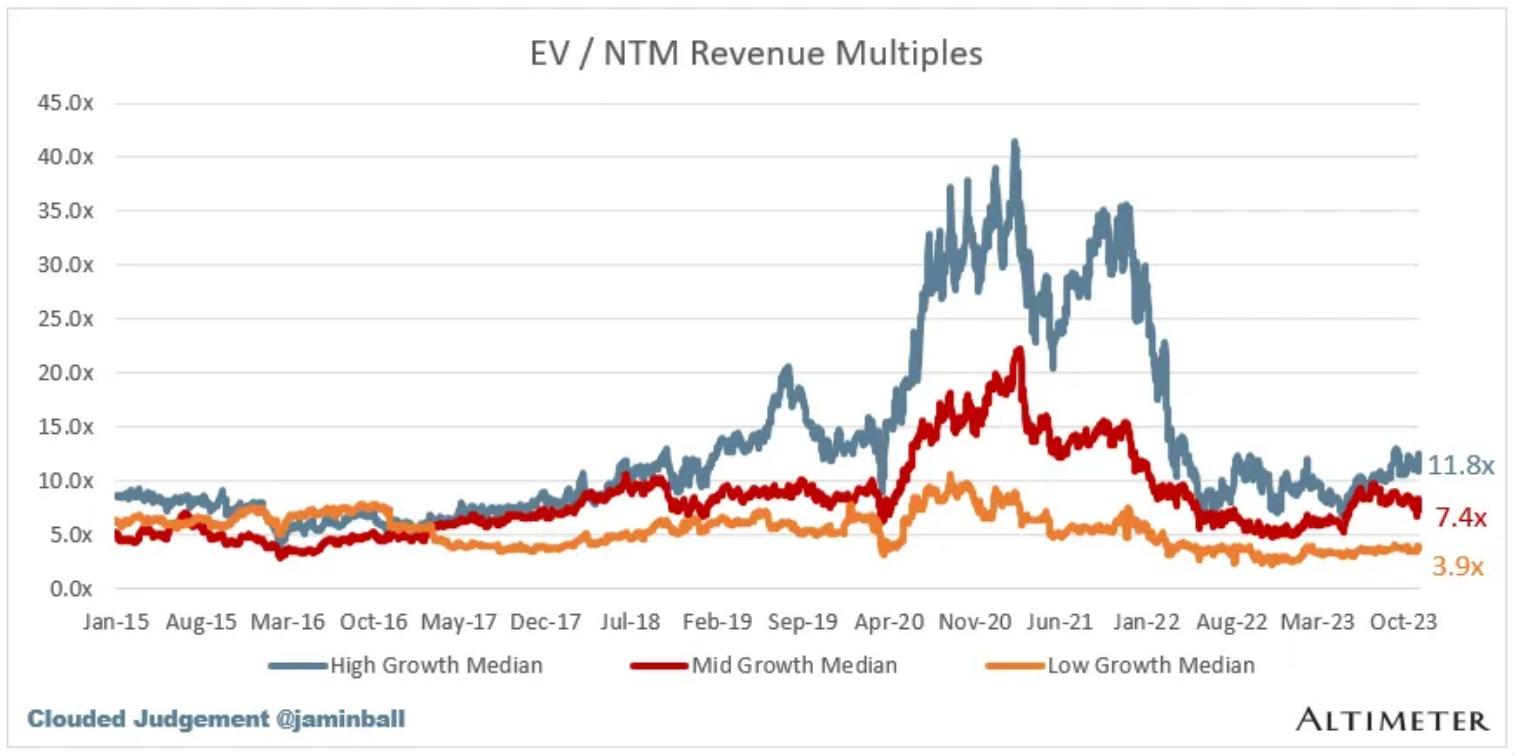

In [39]:
display_image_base64(docs[2])

In [40]:
result = chain_multimodal_rag.invoke(query)

from IPython.display import Markdown as md
md(result)

 | Company | EV/NTM Rev | NTM Rev Growth |
|---|---|---|
| MongoDB | 14.6x | 17% |
| Cloudflare | 13.4x | 28% |
| Datadog | 13.1x | 19% |